In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx
import quadax

from jax.scipy.special import gammaincc, erf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.network import get_network_eval_fn
from lib.trafos import transform_network_outputs, transform_network_inputs
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

In [2]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [176]:
from lib.c_mpe_gamma import c_multi_gamma_mpe_prob_midpoint2, c_multi_gamma_mpe_prob_pure_jax
from lib.cgamma_biweight_log_mpe_prob import c_multi_gamma_biweight_mpe_logprob_v1d
from lib.cgamma import c_multi_gamma_mpe_prob, postjitter_c_multi_gamma_mpe_prob, c_multi_gamma_mpe_prob_v1d_x

In [361]:
from jax.scipy.stats.norm import pdf as norm_pdf

'''
def postjitter_c_mpe_biweight(x, mix_probs, a, b, n, sigma=3.0, sigma_post=2.0):
    __sigma_scale = 3.0
    nmax = 5.0
    nint1 = 10
    nint2 = 10
    eps = 1.e-6
    x0 = -sigma * __sigma_scale # start of support of MPE convolved biweight

    xmax = jnp.max(jnp.array([x0 + jnp.array(nmax * sigma_post), x + nmax * sigma_post]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(x0)+eps, x - diff]))
    xmin = jnp.max(jnp.array([jnp.array(x0), x - diff]))
    mid_p = xmin + 0.2 * (xmax-xmin)
    xvals = jnp.concatenate([jnp.linspace(xmin, mid_p, nint1), jnp.linspace(mid_p, xmax, nint2)])

    #xmax = jnp.max(jnp.array([nmax * sigma_post, x + nmax * sigma_post]))
    #diff = xmax-x
    #xmin = jnp.max(jnp.array([jnp.array(x0)+eps, x - diff]))
    #xvals0 = jnp.linspace(jnp.array(x0)+eps, -7.0, 5)
    #xvals1 = jnp.linspace(-7.0, 0.0, 7)
    #xvals2 = jnp.linspace(jnp.max(jnp.array([0.0, xmin])), xmax, 10)
    #xvals = jnp.sort(jnp.concatenate([xvals0, xvals1, xvals2]))

    dx = xvals[1:] - xvals[:-1]
    xvals = 0.5*(xvals[:-1]+xvals[1:])
    return jnp.sum(norm_pdf(xvals, loc=x, scale=sigma_post) * jnp.exp(c_multi_gamma_biweight_mpe_logprob_v1d(xvals, mix_probs, a, b, n, sigma)) * dx)
'''

def postjitter_c_mpe_biweight(x, mix_probs, a, b, n, sigma=3.0, sigma_post=2.0):
    __sigma_scale = jnp.array(3.0)
    nmax = jnp.array(4.0)
    nmin = jnp.array(20.0)
    nint1 = 5
    nint2 = 10
    eps = jnp.array(1.e-6)
    x0 = -sigma * __sigma_scale # start of support of MPE convolved biweight

    xmax = jnp.max(jnp.array([x0 + nmax * sigma_post, x + nmax * sigma_post]))
    xmin = jnp.max(jnp.array([x0, x - nmin * sigma_post]))
    mid_p = xmin + 0.2 * (xmax-xmin)
    xvals = jnp.concatenate([jnp.linspace(xmin, mid_p, nint1), jnp.linspace(mid_p, xmax, nint2)])

    dx = xvals[1:] - xvals[:-1]
    xvals = 0.5*(xvals[:-1]+xvals[1:])
    return jnp.sum(norm_pdf(xvals, loc=x, scale=sigma_post) * jnp.exp(c_multi_gamma_biweight_mpe_logprob_v1d(xvals, mix_probs, a, b, n, sigma)) * dx)

postjitter_c_mpe_biweight_v = jax.jit(jax.vmap(postjitter_c_mpe_biweight, (0, 0, 0, 0, 0, None, None), 0))



def postjitter_c_multi_gamma_mpe_prob(x, mix_probs, a, b, n, sigma=3.0, sigma_post=2.0):
    nmax = 5.0
    nmin = 10.0
    nint1 = 10
    nint2 = 10
    x0 = -14.0 # early integration start
    x1 = -1.0 # early integration end
    delta = 1.0


    xmin = jnp.max(jnp.array([x0, x - nmin * sigma_post]))
    xmax = jnp.max(jnp.array([x0 + nmax * sigma_post, x + nmax * sigma_post]))
    
    xvals = jnp.concatenate([jnp.linspace(x0, x1, nint1), x * jnp.ones(1), jnp.linspace(xmin, xmax, nint2)])
    xvals = jnp.sort(xvals)
    dx = xvals[1:] - xvals[:-1]
    xvals = 0.5*(xvals[:-1]+xvals[1:])
    return jnp.sum(norm_pdf(xvals, loc=x, scale=sigma_post) * c_multi_gamma_mpe_prob_v1d_x(xvals, mix_probs, a, b, n, sigma, delta) * dx)

In [362]:
convolved_mpe_biweight_postjitter_v1d_x = jax.jit(jax.vmap(postjitter_c_mpe_biweight, (0, None, None, None, None, None, None), 0))
convolved_post_mpe_approx_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_midpoint2, (0, None, None, None, None, None), 0))
convolved_post_mpe_exact_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax, (0, None, None, None, None, None), 0))
convolved_cgamma_mpe_prob_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob, (0, None, None, None, None, None, None), 0))
convolved_postjitter_cgamma_mpe_prob_v1d_x = jax.jit(jax.vmap(postjitter_c_multi_gamma_mpe_prob, (0, None, None, None, None, None, None), 0))

In [392]:
dist = 100
z = -500
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs)

[3.97672699 5.78965668 2.50187835] [0.00778667 0.02569518 0.00205566]


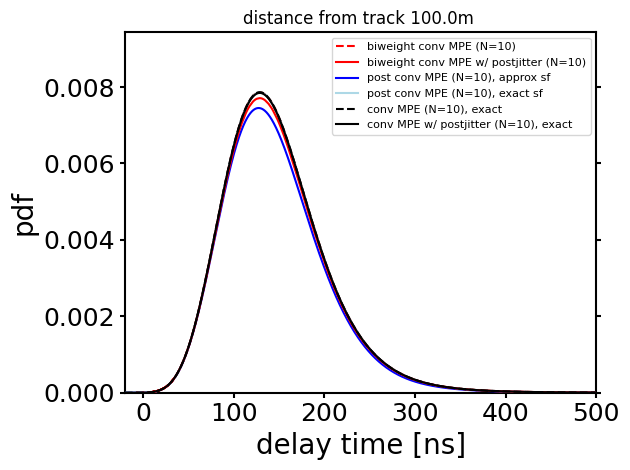

In [397]:
from matplotlib.pyplot import cm

n_p = 10

fig, ax = plt.subplots()
xvals = np.linspace(-50, 500, 10000)

y_max = 0
ys_conv_mpe_biweight = jnp.exp(c_multi_gamma_biweight_mpe_logprob_v1d(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0)))
plt.plot(xvals, ys_conv_mpe_biweight, label=f'biweight conv MPE (N={n_p:.0f})', color='red', linestyle='dashed', zorder=100)
#y_max = np.amax([y_max, np.nanmax(ys_conv_mpe_biweight)])

y_max = 0
ys_post_conv_mpe_biweight = convolved_mpe_biweight_postjitter_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0), jnp.array(2.0))
plt.plot(xvals, ys_post_conv_mpe_biweight, label=f'biweight conv MPE w/ postjitter (N={n_p:.0f})', color='red', linestyle='solid', zorder=101)
y_max = np.amax([y_max, np.nanmax(ys_post_conv_mpe_biweight)])

ys_post_conv_mpe_approx = convolved_post_mpe_approx_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys_post_conv_mpe_approx, label=f'post conv MPE (N={n_p:.0f}), approx sf', color='blue', linestyle='solid', zorder=100)
y_max = np.amax([y_max, np.nanmax(ys_post_conv_mpe_approx)])

ys_post_conv_mpe = convolved_post_mpe_exact_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys_post_conv_mpe , label=f'post conv MPE (N={n_p:.0f}), exact sf', color='lightblue', linestyle='solid', zorder=100)
y_max = np.amax([y_max, np.nanmax(ys_post_conv_mpe)])

ys_cgamma_mpe = convolved_cgamma_mpe_prob_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0), jnp.array(1.0))
plt.plot(xvals, ys_cgamma_mpe, label=f'conv MPE (N={n_p:.0f}), exact', color='black', linestyle='dashed', zorder=105)
#y_max = np.amax([y_max, np.nanmax(ys_cgamma_mpe)])

ys_cgamma_mpe_post_conv = convolved_postjitter_cgamma_mpe_prob_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0), jnp.array(2.0))
plt.plot(xvals, ys_cgamma_mpe_post_conv, label=f'conv MPE w/ postjitter (N={n_p:.0f}), exact', color='black', linestyle='solid', zorder=500)
y_max = np.amax([y_max, np.nanmax(ys_cgamma_mpe_post_conv)])



plot_args = {'xlim':[-20, 500],
                     'ylim':[0.0, 1.2*y_max],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

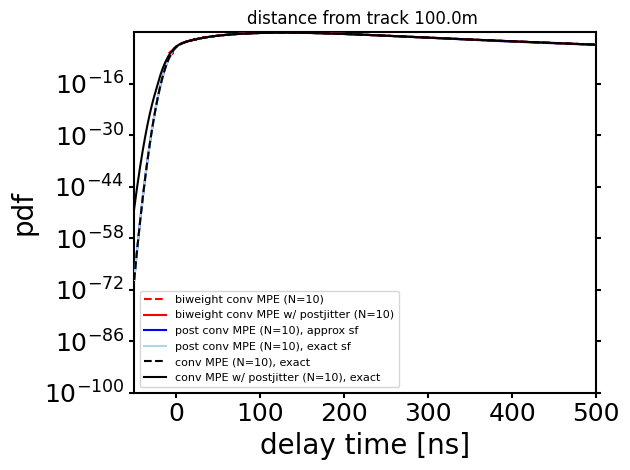

In [398]:
from matplotlib.pyplot import cm

fig, ax = plt.subplots()

y_max = 0
plt.plot(xvals, ys_conv_mpe_biweight, label=f'biweight conv MPE (N={n_p:.0f})', color='red', linestyle='dashed', zorder=100)
#y_max = np.amax([y_max, np.nanmax(ys_conv_mpe_biweight)])

y_max = 0
plt.plot(xvals, ys_post_conv_mpe_biweight, label=f'biweight conv MPE w/ postjitter (N={n_p:.0f})', color='red', linestyle='solid', zorder=101)
y_max = np.amax([y_max, np.nanmax(ys_post_conv_mpe_biweight)])

plt.plot(xvals, ys_post_conv_mpe_approx, label=f'post conv MPE (N={n_p:.0f}), approx sf', color='blue', linestyle='solid', zorder=100)
y_max = np.amax([y_max, np.nanmax(ys_post_conv_mpe_approx)])

plt.plot(xvals, ys_post_conv_mpe , label=f'post conv MPE (N={n_p:.0f}), exact sf', color='lightblue', linestyle='solid', zorder=100)
y_max = np.amax([y_max, np.nanmax(ys_post_conv_mpe)])

plt.plot(xvals, ys_cgamma_mpe, label=f'conv MPE (N={n_p:.0f}), exact', color='black', linestyle='dashed', zorder=105)
#y_max = np.amax([y_max, np.nanmax(ys_cgamma_mpe)])

plt.plot(xvals, ys_cgamma_mpe_post_conv, label=f'conv MPE w/ postjitter (N={n_p:.0f}), exact', color='black', linestyle='solid', zorder=500)
y_max = np.amax([y_max, np.nanmax(ys_cgamma_mpe_post_conv)])


plot_args = {'xlim':[-50, 500],
                     'ylim':[1.e-100, 1.2*y_max],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.yscale('log')
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

In [375]:
dx = xvals[1] - xvals[0]
np.nansum(ys_post_conv_mpe_biweight * dx)

0.9719145404820453

In [376]:
dx = xvals[1] - xvals[0]
np.nansum(ys_cgamma_mpe_post_conv * dx)

1.1312090664236294

In [267]:
ys_post_conv_mpe_biweight

Array([2.00403704e-99, 2.03547605e-99, 2.06740712e-99, ...,
       1.01582834e-16, 1.01572038e-16, 1.01560127e-16], dtype=float64)

In [136]:
print(ys_post_conv_mpe_biweight)

[       nan        nan        nan ... 0.00036304 0.00036307 0.00036302]
